## Pontificia Universidad Javeriana

Autor: Diego Alejandro Jara Rojas.

Fecha: 5/11/2025

## **Problemática**
En los procesos de análisis de datos es frecuente contar con grandes volúmenes de información sin etiquetas o categorías predefinidas.
Identificar patrones y grupos naturales dentro de estos datos es un desafío común en la minería y analítica no supervisada.

En este caso, se busca analizar el conjunto de datos Iris, ampliamente utilizado en el campo de la inteligencia artificial, con el fin de descubrir agrupaciones naturales de flores según sus características morfológicas (longitud y ancho de sépalos y pétalos), sin utilizar las etiquetas de especie como referencia.

## **Objetivo**
El objetivo de este cuaderno es aplicar el algoritmo de clustering a un conjunto de datos sencillos. 

## **Metodología**
1. Importación de los datos: Se carga el conjunto de datos Iris en un DataFrame de PySpark.

2. Reporte de calidad de datos: Se realiza una verificación inicial de valores nulos, datos inconsistentes o faltantes mediante funciones de inspección en PySpark.

3. Preprocesamiento y limpieza: Aplicar indexador, el escalador y el vector para que el modelo pueda leer los datos. 

4. Modelado y evaluación: Se entrena el modelo de K-Means variando el número de clústeres (k) y se evalúan los resultados utilizando el índice de silueta y el Within Set Sum of Squared Errors (WSSSE).

5. Visualización de resultado: Se generan representaciones gráficas de los clústeres mediante Matplotlib y Seaborn para analizar visualmente la separación y cohesión de los grupos.

<h2>Clustering</h2>

<h2>Indice</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ul>
  <li>Cargar los Datos</li>
  <li>Aplicando Algortimo K-Medias</li>
</ul>

Tiempo estimado: <strong>10 min</strong>

</div>
<hr>

<h3>Cargar los datos</h3>

Para este ejercicio se estará utilizando el conjunto de datos Iris, la cual es una fuente en línea en formato CSV (valores separados por coma).
<p> Este set de datos posee diferentes medidas sobre la planta Iris y es famosamente utilizado como ejemplo en analítica de datos:
  </p>
Se utiliza este conjunto para ejemplificar la creación de clusters:

<ul>
  <li>descripción: <a href="https://archive.ics.uci.edu/ml/datasets/Iris" target="_blank">https://archive.ics.uci.edu/ml/datasets/Iris</a></li>
  <li>fuente de datos: <a href="https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data" target="_blank">https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data</a></li>
    <li>tipo de datos: csv</li>

Se va a utilizar la librería Pandas de Python para realizar la lectura de archivos. Se cargan los datos, se agregan cabeceras y se muestra el resultado:

In [1]:
import sys
print(sys.executable)

/home/estudiante/miniconda3/bin/python3


In [2]:
#Importación de todas las bibliotecas necesarias para procesamiento, gráficas y otros recursos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Bibliotecas especializadas
from pylab import *

In [3]:
import os

# Ajuste de las variables de entorno
os.environ["PYSPARK_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/home/estudiante/miniconda3/bin/python3"

print("Usando Python en:", os.environ["PYSPARK_PYTHON"])

Usando Python en: /home/estudiante/miniconda3/bin/python3


In [4]:
# Bibliotecas de Contexto PySpark, MLlib y contexto para levantar la sesión de PYSPARK

#Búsqueda de inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F # Acceso a todas las funciones
from pyspark.sql.functions import when, isnan, col, count

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler


from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
#Se crea una sesión para hacer el contexto de procesamiento desde mi Cuota de cluster 
from pyspark import SparkConf
##Se levanta la configuración de mi Cuota
configura = SparkConf().set("spark.scheduler.mode", "FAIR")

configura.setAppName("Iris_Jara")

sparkA = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext = sparkA.sparkContext, sparkSession = sparkA)

contextosparkA = sparkA.sparkContext.getOrCreate()

print("Sesión cluster HPC: Jara")

sparkA

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 22:07:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Sesión cluster HPC: Jara


In [6]:
# Leer datos desde archivo CSV
import wget
url_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
local_path ="/almacen/csv/iris.data"
wget.download(url_path,local_path)

schema = StructType([StructField("sepal_length", FloatType(), True),
                     StructField("sepal_width",  FloatType(), True),
                     StructField("petal_length", FloatType(), True),
                     StructField("petal_width",  FloatType(), True),
                     StructField("Species",        StringType(), True)])


df00 = sparkA.read.format("csv").option("header", "false").schema(schema).load(local_path)

df00.show(5)

-1 / unknown

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



Se imprime el esquema del dataframe leido con el objetivo de comprobar cuales son las columnas y sus tipos.
Esto va a ser util más adelante cuando se implemente k-means, debido a que este solo funciona con valores continuos.

In [7]:
df00.printSchema()

root
 |-- sepal_length: float (nullable = true)
 |-- sepal_width: float (nullable = true)
 |-- petal_length: float (nullable = true)
 |-- petal_width: float (nullable = true)
 |-- Species: string (nullable = true)



Luego se comprueba de que no existen valores faltantes o nulos en el dataframe:

In [8]:
df00.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c)
             for c in df00.columns
            ]).show()

+------------+-----------+------------+-----------+-------+
|sepal_length|sepal_width|petal_length|petal_width|Species|
+------------+-----------+------------+-----------+-------+
|           0|          0|           0|          0|      0|
+------------+-----------+------------+-----------+-------+



Este paso resulta fundamental, ya que para construir un modelo que represente de manera precisa las relaciones entre las variables, es necesario contar con datos limpios y consistentes.


### Aplicar Indexador a Columna "Species"

In [9]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# StringIndexer Initialization
indexer = StringIndexer(inputCol="Species", outputCol="Species_Indexed")
indexerModel = indexer.fit(df00)

# Transform the DataFrame using the fitted StringIndexer model
indexed_df = indexerModel.transform(df00)
indexed_df.show()

+------------+-----------+------------+-----------+-----------+---------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|Species_Indexed|
+------------+-----------+------------+-----------+-----------+---------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|            0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|            0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|            0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|            0.0|
|         5.4|        3.9|         1.7|        0.4|Iris-setosa|            0.0|
|         4.6|        3.4|         1.4|        0.3|Iris-setosa|            0.0|
|         5.0|        3.4|         1.5|        0.2|Iris-setosa|            0.0|
|         4.4|        2.9|         1.4|        0.2|Iris-setosa|            0.0|
|         4.9|        3.1|         1.5| 

En este paso se aplica el transformador StringIndexer de Spark MLlib, el cual convierte la variable categórica Species en una variable numérica denominada Species_Indexed.

Este proceso es necesario porque los algoritmos de agrupamiento, como K-Means, solo pueden operar con valores numéricos.
Así, cada especie de flor se representa mediante un identificador numérico que facilita el procesamiento posterior del modelo.

In [10]:
indexed_df.select('Species').distinct().collect()

[Row(Species='Iris-virginica'),
 Row(Species='Iris-setosa'),
 Row(Species='Iris-versicolor')]

Despues se comprueba que el indexador detectó correctamente cada una de las categorías únicas presentes en la columna Species.

En este caso, se identifican tres especies distintas (Iris-setosa, Iris-versicolor e Iris-virginica), confirmando la correcta lectura y estructura del conjunto de datos antes de continuar con su transformación y análisis.

<h3>Aplicar Algortimo K-Medias (K-Means)</h3>

Ahora, para realizar el algoritmo K-Means, solo se pueden utilizar valores numericos, por lo tanto en este paso se seleccionan solo las columnas numéricas:

In [11]:
df_kmeans = df00[["sepal_length","sepal_width","petal_length","petal_width"]]
df_kmeans.show(5)

+------------+-----------+------------+-----------+
|sepal_length|sepal_width|petal_length|petal_width|
+------------+-----------+------------+-----------+
|         5.1|        3.5|         1.4|        0.2|
|         4.9|        3.0|         1.4|        0.2|
|         4.7|        3.2|         1.3|        0.2|
|         4.6|        3.1|         1.5|        0.2|
|         5.0|        3.6|         1.4|        0.2|
+------------+-----------+------------+-----------+
only showing top 5 rows



### Formatear los datos usando Vector Assembler en los vectores los cuales serán usados como "features"

En este paso se emplea el transformador VectorAssembler de Spark MLlib, con el objetivo de combinar las variables numéricas en una sola columna denominada features.

Esta columna contiene los vectores que representan las observaciones, permitiendo calcular distancias entre los puntos durante la aplicación del algoritmo de K-Means.
Este formato es el requerido por los modelos de aprendizaje automático en Spark.

In [48]:
assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol='features')
df_datos = assembler.transform(df00)

### Escalar los datos

En este paso se aplica la estandarización de los datos mediante el transformador StandardScaler en el vector generado anteriormente, el cual ajusta cada variable según su desviación estándar.

Esto asegura que todas las características tengan una escala comparable, evitando que las variables con valores mayores dominen el cálculo de las distancias durante el proceso de clustering.

Como resultado, se genera una nueva columna denominada scaledFeatures, que contiene los vectores normalizados listos para la aplicación del algoritmo K-Means.

In [51]:
# Crear el objeto escalador
escalador = StandardScaler(
    inputCol='features',      
    outputCol='scaledFeatures', 
    withStd=True,              
    withMean=False             
)

# Compute summary statistics by fitting the StandardScaler
modeloEscalado = escalador.fit(df_datos)

# Normalize each feature to have unit standard deviation.
df_datos = modeloEscalado.transform(df_datos)

df_datos.show(5)

+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|sepal_length|sepal_width|petal_length|petal_width|    Species|            features|      scaledFeatures|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|[5.09999990463256...|[6.15892840615775...|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|[4.90000009536743...|[5.91740202781600...|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|[4.69999980926513...|[5.67587507362994...|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|[4.59999990463256...|[5.55511188445906...|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|[5.0,3.5999999046...|[6.03816521698687...|
+------------+-----------+------------+-----------+-----------+--------------------+--------------------+
only showing top 5 rows



### Encontrar el número de clusters usando Silhouette Score

En esta etapa se implementa el algoritmo de K-Means de Spark MLlib, probando diferentes valores de k (de 2 a 9) con el fin de determinar el número óptimo de clústeres.

- Para evaluar el desempeño del modelo se utiliza la métrica de la silueta, considerando la distancia euclidiana como medida de similitud.
- Los valores predichos por el algoritmo se almacenan en una nueva columna denominada prediction, que indica el clúster asignado a cada observación.

In [52]:
#Importing the model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score=[]

evaluador = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='scaledFeatures', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='scaledFeatures', k=i)
    KMeans_fit=kmeans.fit(df_datos)
    output = KMeans_fit.transform(df_datos)   
    score = evaluador.evaluate(output)   
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.7714149115179729
Silhouette Score for k = 3 is 0.6521533475110602
Silhouette Score for k = 4 is 0.5742954844947088
Silhouette Score for k = 5 is 0.5130711401908112
Silhouette Score for k = 6 is 0.4982583022291411
Silhouette Score for k = 7 is 0.4864038588151551
Silhouette Score for k = 8 is 0.441329982540054
Silhouette Score for k = 9 is 0.42138753531262035


El índice de silueta evalúa simultáneamente la cohesión interna de los clústeres (qué tan similares son los puntos dentro de un mismo grupo) y su separación respecto a otros clústeres.
Los valores cercanos a 1 indican una estructura de grupos bien definida, mientras que valores próximos a 0 o negativos reflejan solapamiento o una mala asignación de los datos.

En este caso, los resultados muestran que el valor del índice de silueta disminuye progresivamente de 0.77 con 2 clústeres a 0.42 con 9 clústeres, lo cual indica que la mejor representación de los datos se obtiene con dos clústeres, al presentar la mayor cohesión y separación entre grupos.

### Visualización de silhouette scores

Ahora, graficamos para visualizar gráficamente el índice de siluta en diferente número de clusteres. 

Se observa que el valor máximo se alcanza cuando k = 2, lo que confirma que el modelo con dos clústeres proporciona la mejor cohesión interna y separación entre grupos.
A medida que aumenta k, el valor del índice disminuye, indicando una pérdida en la calidad del agrupamiento.

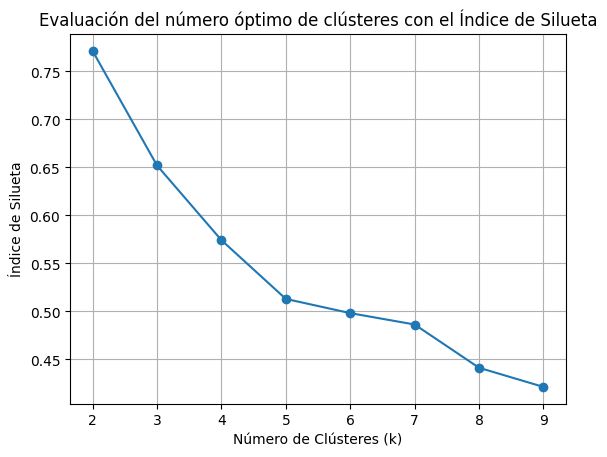

In [53]:
import matplotlib.pyplot as plt

plt.plot(range(2,10), silhouette_score, marker='o', linestyle='-')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Índice de Silueta')
plt.title('Evaluación del número óptimo de clústeres con el Índice de Silueta')
plt.grid(True)
plt.show()

- Por lo tanto se selecciona k=2, debido a que tiene el mayor indice de silueta (Y por lo tanto la mejor cohesión interna y separación entre grupos.)
- Comparando los resultados con k mayores, vemos que el indice va disminuyendo, y por lo tanto, representa a los datos de una peor manera.

### Entrenar el modelo

En esta etapa se entrena el modelo de K-Means utilizando el valor óptimo de k = 2 obtenido previamente mediante la métrica de silueta.

El modelo toma como entrada la columna scaledFeatures, que contiene las variables normalizadas, y genera una nueva columna denominada cluster, donde se asigna a cada observación el clúster correspondiente.

In [74]:
kmeans = KMeans(k=2, featuresCol="scaledFeatures", predictionCol="cluster")
kmeans_model = kmeans.fit(df_datos)

### Evaluar el modelo k=2 Within Set Sum of Squared Errors (WSSSE) metric

Para evaluar el modelo con k = 2, se calculó una métrica diferente: el Within Set Sum of Squared Errors (WSSSE), el cual mide la suma de las distancias cuadradas entre cada punto y su centroide.

Este valor permite estimar la compactación interna de los clústeres; a menor WSSSE, mayor cohesión dentro de los grupos.

In [75]:
output = kmeans_model.transform(df_datos)
wssse = kmeans_model.summary.trainingCost
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 222.24045714435584


El modelo con k = 2 obtuvo un Within Set Sum of Squared Errors (WSSSE) de 222.24

Este valor refleja que los puntos están cercanos a sus respectivos centroides.

### Visualizar los Datos

En este paso se realizaron varias visualización bidimensional de los resultados del algoritmo K-Means empleando las variables longitud y ancho del sépalo.
Cada punto representa una observación del conjunto de datos, y su color indica el clúster al que fue asignado.


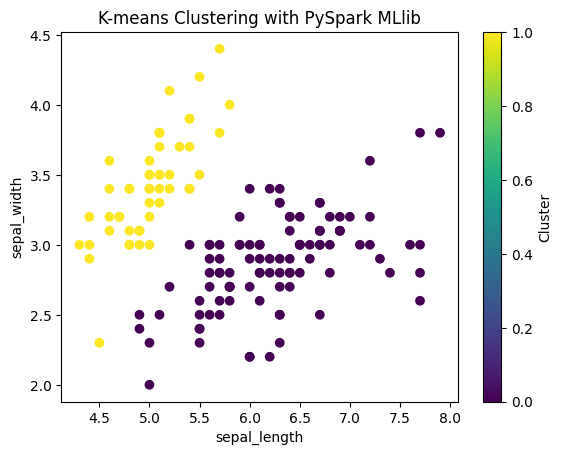

In [76]:
# Converting to Pandas DataFrame
clustered_data_pd = output.toPandas()
 
# Visualizing the results
plt.scatter(clustered_data_pd["sepal_length"], clustered_data_pd["sepal_width"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("sepal_length")
plt.ylabel("sepal_width")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

En la primera figura se presenta la visualización del resultado del modelo K-Means con k = 2, utilizando las variables longitud y ancho del sépalo.

Se observan dos grupos bien diferenciados: uno con sépalos más cortos y anchos, y otro con sépalos más largos y estrechos.

Esta segmentación coincide con la estructura natural del conjunto de datos, donde una de las especies se distingue claramente de las demás.

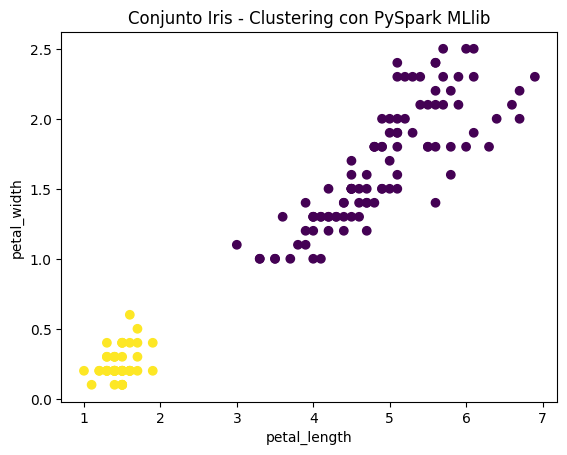

In [84]:
#Visualizando con Matplotlib
import matplotlib.pyplot as plt
import numpy as np

n_clusters = clustered_data_pd["cluster"].nunique()
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

plt.scatter(
    x=clustered_data_pd["petal_length"],
    y=clustered_data_pd["petal_width"],
    c=colors[clustered_data_pd["cluster"]],
)
plt.title("Conjunto Iris - Clustering con PySpark MLlib")
plt.xlabel("petal_length")
plt.ylabel("petal_width")
plt.show()


La segunda gráfica muestra una separación muy clara entre dos grupos de flores según las dimensiones de sus pétalos, visualizada con Matplotlib.

El primer clúster (amarillo) representa flores con pétalos pequeños y estrechos, mientras que el segundo (morado) agrupa flores con pétalos más grandes y anchos.
Esta segmentación confirma que el modelo K-Means con k = 2 identifica correctamente la estructura natural del conjunto Iris, distinguiendo a Iris-setosa de las demás especies.

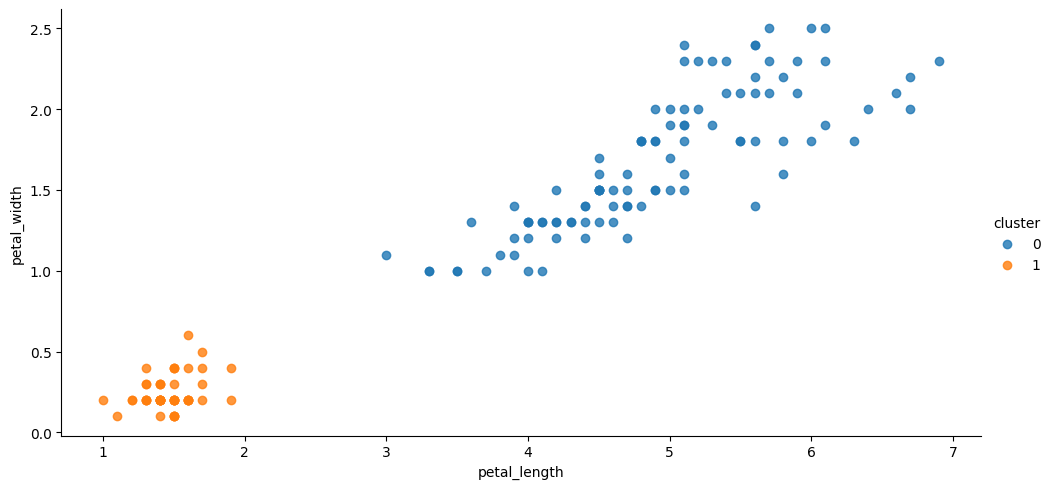

In [94]:
#Visualizando con Seaborn
import seaborn as sns
clustered_data_pd["cluster"] = labels
sns.lmplot(x='petal_length',y='petal_width',data=clustered_data_pd,hue='cluster',fit_reg=False, height = 5, aspect = 2)

La última visualización, obtenida con Seaborn, muestra de manera clara la segmentación del conjunto Iris en dos grupos a partir de las variables petal_length y petal_width.

El primer clúster (naranja) agrupa las flores con pétalos pequeños y estrecho, mientras que el segundo (azul) contiene flores con pétalos más grandes y anchos.

Esta representación confirma la correcta partición obtenida por el modelo K-Means con k = 2, evidenciando la separación natural existente entre las especies del conjunto de datos.

In [95]:
sparkA.stop()

## Conclusiones

En este ejercicio se aplicó el algoritmo K-Means al conjunto de datos Iris utilizando PySpark MLlib.

Tras la limpieza, codificación y normalización de los datos, se evaluaron distintos valores de k mediante el índice de silueta, determinando que k = 2 ofrecía la mejor separación (silueta ≈ 0.77).

El modelo final presentó un WSSSE de 222.24 y mostró, en las visualizaciones, dos grupos bien definidos: uno correspondiente a Iris-setosa y otro que agrupa Iris-versicolor e Iris-virginica.

Estos resultados confirman la capacidad del método K-Means para identificar estructuras naturales en los datos, aun sin información supervisada.